In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import os

os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/Kaggle"
%cd /content/gdrive/My Drive/Kaggle

!kaggle datasets download --force -d moltean/fruits
!unzip fruits.zip

In [ ]:
# load libraries 
import os
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
import cv2 
import pandas as pd
import tensorflow as tf 
import seaborn as sn
from keras.utils import np_utils
from sklearn.utils import shuffle
from sklearn.metrics import zero_one_loss,confusion_matrix
from keras.layers import Activation,Dropout,Flatten,Dense,MaxPooling2D
from keras.layers import GlobalAveragePooling2D,Conv2D,BatchNormalization,Dropout
from keras.applications.vgg16 import VGG16
from keras.applications import MobileNetV2,MobileNet,ResNet50
from keras.models import Model
from keras.callbacks import EarlyStopping


type_fruits =["Apple","Banana","Plum","Cherry","Grape ","Pear","Peach","Pepper","Tomato","Potato"]

train_dir = 'fruits-360/Training'
test_dir = 'fruits-360/Test'

IMAGE_SIZE = (32,32)
trainLables, trainImages=[], []
testLables, testImages=[], []

# load data
def load_data(directory,image_list,lable_list):
    for root, dirs, files in os.walk(directory, topdown=False):
        for dir_name in dirs: 
            for type_name in type_fruits: 
                if dir_name.startswith(type_name):                    
                    for filenames in os.listdir(directory +"/"+dir_name):      
                        image = cv2.imread(directory +"/"+ dir_name +"/"+filenames)
                        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                        image = cv2.resize(image, IMAGE_SIZE) 
                        image_list.append(image)
                        lable_list.append(type_fruits.index(type_name))
                    
# load train data                   
load_data(train_dir,trainImages,trainLables) 
print('Train images ',len(trainImages))
print('Train lables ',len(trainLables))



# load test data
load_data(test_dir,testImages,testLables) 
print("Test images  ",len(testImages))
print("Test lables  ",len(testLables))



train_images = np.array(trainImages, dtype = 'float32')
train_labels = np.array(trainLables, dtype = 'i')                      
test_images  = np.array(testImages, dtype = 'float32')
test_labels  = np.array(testLables, dtype = 'i')

Train images  32607
Train lables  32607
Test images   10906
Test lables   10906


**Pre Processing data**

In [ ]:
# pre-process the data

train_images = train_images / 255.0
test_images  = test_images / 255.0

# shuffle the data
train_images,train_labels = shuffle(train_images,train_labels)
test_images,test_labels  = shuffle(test_images,test_labels )

no_of_classes = len(np.unique(train_labels))
train_labels = np_utils.to_categorical(train_labels,no_of_classes)
test_labels = np_utils.to_categorical(test_labels,no_of_classes)

**First 9 images after the shuffle**

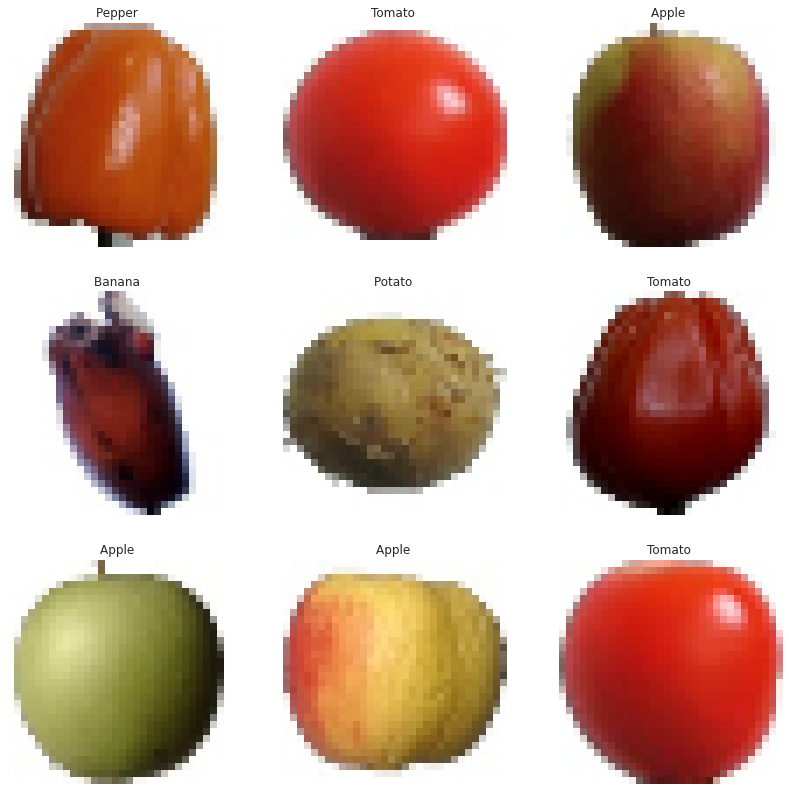

In [ ]:
fig, axis = plt.subplots(3, 3, figsize=(14, 14))
for i, ax in enumerate(axis.flat):
    ax.imshow(test_images[i])        
    test_labels_idx = np.argmax(test_labels[i])
    ax.axis('off')
    ax.set(title = f"{type_fruits[test_labels_idx]} ")

In [ ]:
modelFFN1 = tf.keras.Sequential()
modelFFN1.add(Dense(12,input_shape = (32,32, 3), activation='relu'))
modelFFN1.add(Flatten()) 
modelFFN1.add(Dense(10 , activation='sigmoid')) 
modelFFN1.compile(loss ='categorical_crossentropy',optimizer ='adam',metrics =['accuracy'])
modelFFN1.summary()

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_60 (Dense)             (None, 32, 32, 12)        48        
_________________________________________________________________
flatten_17 (Flatten)         (None, 12288)             0         
_________________________________________________________________
dense_61 (Dense)             (None, 10)                122890    
Total params: 122,938
Trainable params: 122,938
Non-trainable params: 0
_________________________________________________________________


In [ ]:
historyFFN1 = modelFFN1.fit(train_images, train_labels, epochs=10
          ,validation_data=(test_images, test_labels) )

Epoch 1/10
1019/1019 [==============================] - 5s 4ms/step - loss: 0.7734 - accuracy: 0.7579 - val_loss: 0.4033 - val_accuracy: 0.8625
Epoch 2/10
1019/1019 [==============================] - 4s 4ms/step - loss: 0.0783 - accuracy: 0.9849 - val_loss: 0.2287 - val_accuracy: 0.9098
Epoch 3/10
1019/1019 [==============================] - 4s 4ms/step - loss: 0.0314 - accuracy: 0.9952 - val_loss: 0.1771 - val_accuracy: 0.9418
Epoch 4/10
1019/1019 [==============================] - 4s 4ms/step - loss: 0.0159 - accuracy: 0.9974 - val_loss: 0.1372 - val_accuracy: 0.9509
Epoch 5/10
1019/1019 [==============================] - 4s 4ms/step - loss: 0.0095 - accuracy: 0.9985 - val_loss: 0.2440 - val_accuracy: 0.9232
Epoch 6/10
1019/1019 [==============================] - 4s 4ms/step - loss: 0.0133 - accuracy: 0.9974 - val_loss: 0.1546 - val_accuracy: 0.9503
Epoch 7/10
1019/1019 [==============================] - 4s 4ms/step - loss: 0.0032 - accuracy: 0.9997 - val_loss: 0.1367 - val_accuracy:

In [ ]:
modelFFN1.evaluate(test_images,  test_labels, verbose=2)

341/341 - 1s - loss: 0.1175 - accuracy: 0.9621


[0.11754690855741501, 0.9621309638023376]

**Zero one loss function**

In [ ]:
def zero_one(pred_labels,test_labels):

    pred_labels_idx = []
    for i in range(len(pred_labels)):
        pred_labels_idx.append(np.argmax(pred_labels[i])) 
    
    test_labels_idx = []
    for i in range(len(test_labels)):
        test_labels_idx.append(np.argmax(test_labels[i]))     

    return zero_one_loss(test_labels_idx, pred_labels_idx)

In [ ]:
pred_labels = modelFFN1.predict(test_images)
zo_lossFFN1 = zero_one(pred_labels,test_labels)
print("Zero one loss: ",zo_lossFFN1)

Zero one loss:  0.037869062901155326


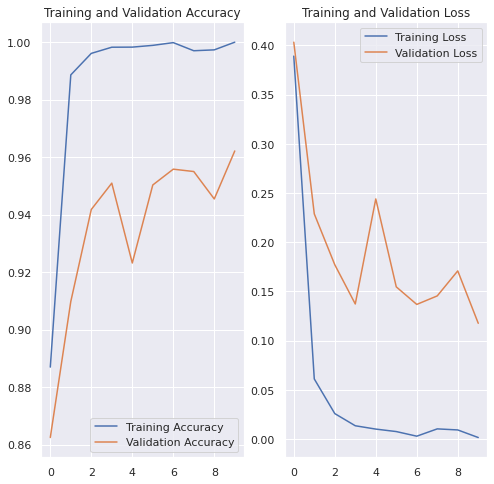

In [ ]:
acc = historyFFN1.history['accuracy']
val_acc = historyFFN1.history['val_accuracy']

loss = historyFFN1.history['loss']
val_loss = historyFFN1.history['val_loss']

epochs_range = range(10)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

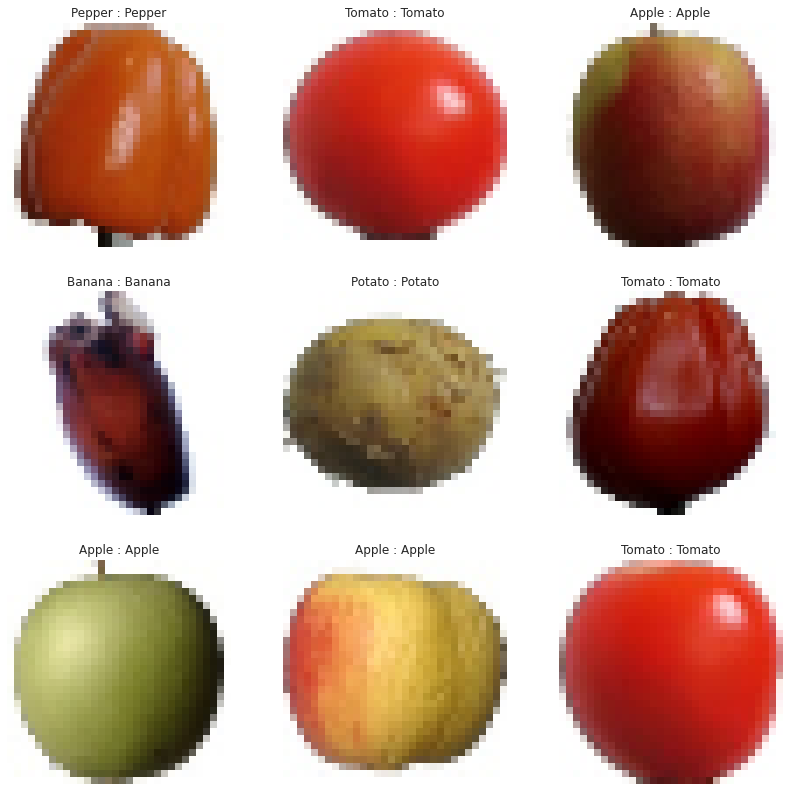

In [ ]:
fig, axis = plt.subplots(3, 3, figsize=(14, 14))
for i, ax in enumerate(axis.flat):
    ax.imshow(test_images[i])    
    pred_idx = np.argmax(pred_labels[i])
    test_labels_idx = np.argmax(test_labels[i])
    ax.axis('off')
    ax.set(title = f"{type_fruits[test_labels_idx]} : {type_fruits[pred_idx]}")

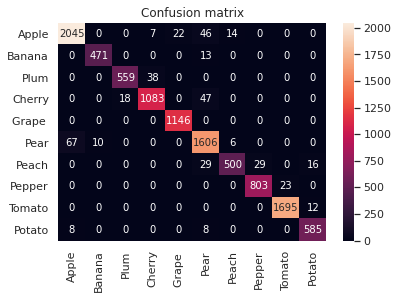

In [ ]:
sn.set(font_scale=1.0)
pred_labels_idx = []
for i in range(len(pred_labels)):
    pred_labels_idx.append(np.argmax(pred_labels[i])) 
    
test_labels_idx = []
for i in range(len(test_labels)):
    test_labels_idx.append(np.argmax(test_labels[i])) 

CM = confusion_matrix(test_labels_idx, pred_labels_idx)
ax = plt.axes()
sn.heatmap(CM, annot=True, 
           annot_kws={"size": 10}, 
           fmt="d",
           xticklabels=type_fruits, 
           yticklabels=type_fruits, ax = ax)
ax.set_title('Confusion matrix')
plt.show()

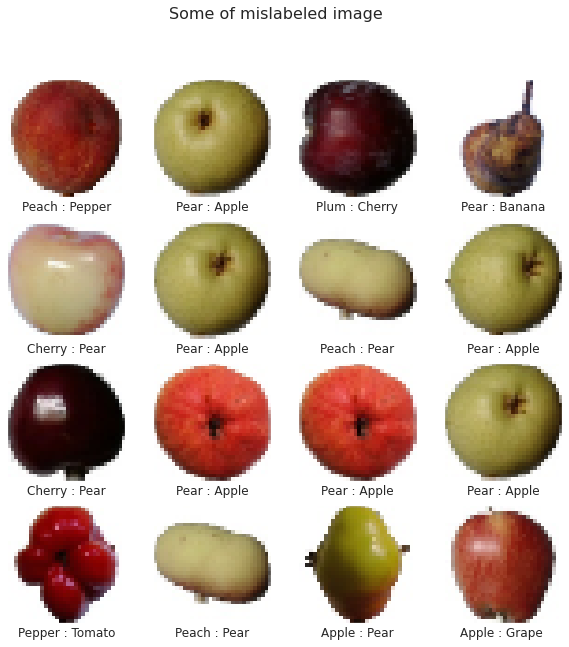

In [ ]:
mislabeled_images_idx =[]

for x in range(len(test_labels_idx)): 
    if(pred_labels_idx[x] != test_labels_idx[x]):
        mislabeled_images_idx.append(x)
#print_mislabeled_images(class_names, test_images, test_labels_idx, y_pred_idx)


fig = plt.figure(figsize=(10,10))
fig.suptitle("Some of mislabeled image", fontsize=16)
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    index   =mislabeled_images_idx[i]    
    real    =type_fruits[test_labels_idx[index]]
    predict =type_fruits[pred_labels_idx[index]]
    plt.xlabel(f"{real} : {predict}")
    plt.imshow(test_images[index], cmap=plt.cm.binary)  
plt.show()

In [ ]:
modelFFN2 = tf.keras.Sequential()
modelFFN2.add(Dense(32,input_shape = (32,32, 3), activation='relu'))
modelFFN2.add(Flatten()) 
modelFFN2.add(Dense(10 , activation='sigmoid')) 

modelFFN2.compile(loss ='categorical_crossentropy', 
                     optimizer ='adam', 
                   metrics =['accuracy']) 
modelFFN2.summary()

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_62 (Dense)             (None, 32, 32, 32)        128       
_________________________________________________________________
flatten_18 (Flatten)         (None, 32768)             0         
_________________________________________________________________
dense_63 (Dense)             (None, 10)                327690    
Total params: 327,818
Trainable params: 327,818
Non-trainable params: 0
_________________________________________________________________


In [ ]:
historyFFN2= modelFFN2.fit(train_images, train_labels, epochs=10
          ,validation_data=(test_images, test_labels) )

Epoch 1/10
1019/1019 [==============================] - 4s 4ms/step - loss: 0.0102 - accuracy: 0.9973 - val_loss: 0.0938 - val_accuracy: 0.9689
Epoch 2/10
1019/1019 [==============================] - 5s 5ms/step - loss: 3.8469e-04 - accuracy: 1.0000 - val_loss: 0.0889 - val_accuracy: 0.9710
Epoch 3/10
1019/1019 [==============================] - 4s 4ms/step - loss: 2.3860e-04 - accuracy: 1.0000 - val_loss: 0.0899 - val_accuracy: 0.9716
Epoch 4/10
1019/1019 [==============================] - 4s 4ms/step - loss: 1.6129e-04 - accuracy: 1.0000 - val_loss: 0.0968 - val_accuracy: 0.9713
Epoch 5/10
1019/1019 [==============================] - 4s 4ms/step - loss: 0.0042 - accuracy: 0.9989 - val_loss: 0.2728 - val_accuracy: 0.9285
Epoch 6/10
1019/1019 [==============================] - 4s 4ms/step - loss: 0.0040 - accuracy: 0.9987 - val_loss: 0.0880 - val_accuracy: 0.9727
Epoch 7/10
1019/1019 [==============================] - 4s 4ms/step - loss: 2.1175e-04 - accuracy: 1.0000 - val_loss: 0.0874

In [ ]:
pred_labels = modelFFN2.predict(test_images)
zo_lossFFN2 = zero_one(pred_labels,test_labels)
print("Zero one loss: ",zo_lossFFN2)

Zero one loss:  0.022923161562442673


In [ ]:
modelFFN3 = tf.keras.Sequential()
modelFFN3.add(Dense(64,input_shape = (32,32, 3), activation='relu'))
modelFFN3.add(Flatten()) 
modelFFN3.add(Dense(10 , activation='sigmoid')) 
modelFFN3.compile(loss ='categorical_crossentropy', 
                     optimizer ='adam', 
                   metrics =['accuracy']) 
modelFFN3.summary()

Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_64 (Dense)             (None, 32, 32, 64)        256       
_________________________________________________________________
flatten_19 (Flatten)         (None, 65536)             0         
_________________________________________________________________
dense_65 (Dense)             (None, 10)                655370    
Total params: 655,626
Trainable params: 655,626
Non-trainable params: 0
_________________________________________________________________


In [ ]:
historyFFN3 = modelFFN3.fit(train_images, train_labels, epochs=10
          ,validation_data=(test_images, test_labels) )

Epoch 1/10
1019/1019 [==============================] - 5s 5ms/step - loss: 0.5971 - accuracy: 0.8229 - val_loss: 0.1418 - val_accuracy: 0.9485
Epoch 2/10
1019/1019 [==============================] - 5s 5ms/step - loss: 0.0175 - accuracy: 0.9981 - val_loss: 0.0830 - val_accuracy: 0.9698
Epoch 3/10
1019/1019 [==============================] - 4s 4ms/step - loss: 0.0110 - accuracy: 0.9982 - val_loss: 0.0662 - val_accuracy: 0.9748
Epoch 4/10
1019/1019 [==============================] - 5s 4ms/step - loss: 0.0026 - accuracy: 0.9997 - val_loss: 0.1551 - val_accuracy: 0.9511
Epoch 5/10
1019/1019 [==============================] - 4s 4ms/step - loss: 0.0117 - accuracy: 0.9979 - val_loss: 0.0523 - val_accuracy: 0.9813
Epoch 6/10
1019/1019 [==============================] - 5s 4ms/step - loss: 7.0913e-04 - accuracy: 1.0000 - val_loss: 0.0497 - val_accuracy: 0.9831
Epoch 7/10
1019/1019 [==============================] - 4s 4ms/step - loss: 3.5009e-04 - accuracy: 1.0000 - val_loss: 0.0487 - val_a

In [ ]:
pred_labels = modelFFN3.predict(test_images)
zo_lossFFN3 = zero_one(pred_labels,test_labels)
print("Zero one loss: ",zo_lossFFN3)

Zero one loss:  0.01797175866495504


In [ ]:
modelFFN4 = tf.keras.Sequential()
modelFFN4.add(Dense(128,input_shape = (32,32, 3), activation='relu'))
modelFFN4.add(Flatten()) 
modelFFN4.add(Dense(10 , activation='sigmoid')) 
modelFFN4.compile(loss ='categorical_crossentropy', 
                     optimizer ='adam', 
                   metrics =['accuracy']) 
modelFFN4.summary()

Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_66 (Dense)             (None, 32, 32, 128)       512       
_________________________________________________________________
flatten_20 (Flatten)         (None, 131072)            0         
_________________________________________________________________
dense_67 (Dense)             (None, 10)                1310730   
Total params: 1,311,242
Trainable params: 1,311,242
Non-trainable params: 0
_________________________________________________________________


In [ ]:
historyFFN4 = modelFFN4.fit(train_images, train_labels, epochs=10
          ,validation_data=(test_images, test_labels) )

Epoch 1/10
1019/1019 [==============================] - 6s 5ms/step - loss: 0.9044 - accuracy: 0.8034 - val_loss: 0.1288 - val_accuracy: 0.9548
Epoch 2/10
1019/1019 [==============================] - 5s 5ms/step - loss: 0.0170 - accuracy: 0.9976 - val_loss: 0.0832 - val_accuracy: 0.9716
Epoch 3/10
1019/1019 [==============================] - 5s 5ms/step - loss: 0.0071 - accuracy: 0.9990 - val_loss: 0.0704 - val_accuracy: 0.9744
Epoch 4/10
1019/1019 [==============================] - 5s 5ms/step - loss: 0.0018 - accuracy: 0.9999 - val_loss: 0.0678 - val_accuracy: 0.9769
Epoch 5/10
1019/1019 [==============================] - 5s 5ms/step - loss: 0.0188 - accuracy: 0.9941 - val_loss: 0.0605 - val_accuracy: 0.9804
Epoch 6/10
1019/1019 [==============================] - 5s 5ms/step - loss: 4.9380e-04 - accuracy: 1.0000 - val_loss: 0.0587 - val_accuracy: 0.9795
Epoch 7/10
1019/1019 [==============================] - 5s 5ms/step - loss: 2.8800e-04 - accuracy: 1.0000 - val_loss: 0.0629 - val_a

In [ ]:
pred_labels = modelFFN4.predict(test_images)
zo_lossFFN4 = zero_one(pred_labels,test_labels)
print("Zero one loss: ",zo_lossFFN4)

Zero one loss:  0.01723821749495691


In [ ]:
modelFFN5 = tf.keras.Sequential()
modelFFN5.add(Dense(256,input_shape = (32,32, 3), activation='relu'))
modelFFN5.add(Flatten()) 
modelFFN5.add(Dense(10 , activation='sigmoid')) 
modelFFN5.compile(loss ='categorical_crossentropy', 
                     optimizer ='adam', 
                   metrics =['accuracy']) 

modelFFN5.summary()

Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_68 (Dense)             (None, 32, 32, 256)       1024      
_________________________________________________________________
flatten_21 (Flatten)         (None, 262144)            0         
_________________________________________________________________
dense_69 (Dense)             (None, 10)                2621450   
Total params: 2,622,474
Trainable params: 2,622,474
Non-trainable params: 0
_________________________________________________________________


In [ ]:
historyFFN5 = modelFFN5.fit(train_images, train_labels, epochs=10
          ,validation_data=(test_images, test_labels) )

Epoch 1/10
1019/1019 [==============================] - 8s 7ms/step - loss: 0.7825 - accuracy: 0.8308 - val_loss: 0.0881 - val_accuracy: 0.9690
Epoch 2/10
1019/1019 [==============================] - 7s 7ms/step - loss: 0.0168 - accuracy: 0.9965 - val_loss: 0.0653 - val_accuracy: 0.9772
Epoch 3/10
1019/1019 [==============================] - 7s 7ms/step - loss: 0.0020 - accuracy: 0.9999 - val_loss: 0.0785 - val_accuracy: 0.9662
Epoch 4/10
1019/1019 [==============================] - 7s 7ms/step - loss: 0.0256 - accuracy: 0.9926 - val_loss: 0.0689 - val_accuracy: 0.9764
Epoch 5/10
1019/1019 [==============================] - 7s 7ms/step - loss: 0.0026 - accuracy: 0.9994 - val_loss: 0.0639 - val_accuracy: 0.9832
Epoch 6/10
1019/1019 [==============================] - 7s 7ms/step - loss: 3.3724e-04 - accuracy: 1.0000 - val_loss: 0.0553 - val_accuracy: 0.9813
Epoch 7/10
1019/1019 [==============================] - 7s 7ms/step - loss: 1.5335e-04 - accuracy: 1.0000 - val_loss: 0.0521 - val_a

In [ ]:
pred_labels = modelFFN5.predict(test_images)
zo_lossFFN5 = zero_one(pred_labels,test_labels)
print("Zero one loss: ",zo_lossFFN5)

Zero one loss:  0.018888685127452787


In [ ]:
modelFFN6 = tf.keras.Sequential()
modelFFN6.add(Dense(512,input_shape = (32,32, 3), activation='relu'))
modelFFN6.add(Flatten()) 
modelFFN6.add(Dense(10 , activation='sigmoid')) 
modelFFN6.compile(loss ='categorical_crossentropy', 
                     optimizer ='adam', 
                   metrics =['accuracy']) 

modelFFN6.summary()

Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_70 (Dense)             (None, 32, 32, 512)       2048      
_________________________________________________________________
flatten_22 (Flatten)         (None, 524288)            0         
_________________________________________________________________
dense_71 (Dense)             (None, 10)                5242890   
Total params: 5,244,938
Trainable params: 5,244,938
Non-trainable params: 0
_________________________________________________________________


In [ ]:
historyFFN6 = modelFFN6.fit(train_images, train_labels, epochs=10
          ,validation_data=(test_images, test_labels) )

Epoch 1/10
1019/1019 [==============================] - 12s 12ms/step - loss: 1.1476 - accuracy: 0.8329 - val_loss: 0.0857 - val_accuracy: 0.9729
Epoch 2/10
1019/1019 [==============================] - 11s 11ms/step - loss: 0.0081 - accuracy: 0.9989 - val_loss: 0.1078 - val_accuracy: 0.9598
Epoch 3/10
1019/1019 [==============================] - 12s 11ms/step - loss: 0.0034 - accuracy: 0.9994 - val_loss: 0.0699 - val_accuracy: 0.9719
Epoch 4/10
1019/1019 [==============================] - 12s 11ms/step - loss: 0.0016 - accuracy: 0.9997 - val_loss: 0.0522 - val_accuracy: 0.9786
Epoch 5/10
1019/1019 [==============================] - 12s 11ms/step - loss: 0.0213 - accuracy: 0.9955 - val_loss: 0.0350 - val_accuracy: 0.9866
Epoch 6/10
1019/1019 [==============================] - 12s 11ms/step - loss: 4.0048e-04 - accuracy: 1.0000 - val_loss: 0.0393 - val_accuracy: 0.9857
Epoch 7/10
1019/1019 [==============================] - 11s 11ms/step - loss: 1.5567e-04 - accuracy: 1.0000 - val_loss: 

In [ ]:
pred_labels = modelFFN6.predict(test_images)
zo_lossFFN6 = zero_one(pred_labels,test_labels)
print("Zero one loss: ",zo_lossFFN6)

Zero one loss:  0.022006235099945037


In [ ]:
modelFFN21 = tf.keras.Sequential()
modelFFN21.add(Dense(64,input_shape = (32,32, 3), activation='relu'))
modelFFN21.add(Flatten()) 
modelFFN21.add(Dense(64 , activation='relu'))
modelFFN21.add(Dense(10 , activation='sigmoid')) 

  
modelFFN21.compile(loss ='categorical_crossentropy', 
                     optimizer ='adam', 
                   metrics =['accuracy']) 

modelFFN21.summary()

Model: "sequential_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_74 (Dense)             (None, 32, 32, 64)        256       
_________________________________________________________________
flatten_24 (Flatten)         (None, 65536)             0         
_________________________________________________________________
dense_75 (Dense)             (None, 64)                4194368   
_________________________________________________________________
dense_76 (Dense)             (None, 10)                650       
Total params: 4,195,274
Trainable params: 4,195,274
Non-trainable params: 0
_________________________________________________________________


In [ ]:
historyFFN21 = modelFFN21.fit(train_images, train_labels, epochs=10
          ,validation_data=(test_images, test_labels) )

Epoch 1/10
1019/1019 [==============================] - 6s 6ms/step - loss: 0.7211 - accuracy: 0.7827 - val_loss: 0.1842 - val_accuracy: 0.9455
Epoch 2/10
1019/1019 [==============================] - 5s 5ms/step - loss: 0.0312 - accuracy: 0.9952 - val_loss: 0.1194 - val_accuracy: 0.9640
Epoch 3/10
1019/1019 [==============================] - 5s 4ms/step - loss: 0.0098 - accuracy: 0.9986 - val_loss: 0.0914 - val_accuracy: 0.9756
Epoch 4/10
1019/1019 [==============================] - 5s 5ms/step - loss: 0.0023 - accuracy: 0.9998 - val_loss: 0.0680 - val_accuracy: 0.9788
Epoch 5/10
1019/1019 [==============================] - 5s 5ms/step - loss: 8.4867e-04 - accuracy: 1.0000 - val_loss: 0.0726 - val_accuracy: 0.9768
Epoch 6/10
1019/1019 [==============================] - 5s 5ms/step - loss: 0.0354 - accuracy: 0.9899 - val_loss: 0.0522 - val_accuracy: 0.9840
Epoch 7/10
1019/1019 [==============================] - 5s 5ms/step - loss: 0.0043 - accuracy: 0.9988 - val_loss: 0.0461 - val_accur

In [ ]:
pred_labels = modelFFN21.predict(test_images)
zo_lossFFN21 = zero_one(pred_labels,test_labels)
print("Zero one loss: ",zo_lossFFN21)

Zero one loss:  0.03686044379240783


In [ ]:
modelFFN22 = tf.keras.Sequential()
modelFFN22.add(Dense(64,input_shape = (32,32, 3), activation='relu'))
modelFFN22.add(Flatten()) 
modelFFN22.add(Dense(64 , activation='relu'))
modelFFN22.add(Dense(64 , activation='relu'))
modelFFN22.add(Dense(10 , activation='sigmoid')) 

  
modelFFN22.compile(loss ='categorical_crossentropy', 
                     optimizer ='adam', 
                   metrics =['accuracy']) 

modelFFN22.summary()

Model: "sequential_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_77 (Dense)             (None, 32, 32, 64)        256       
_________________________________________________________________
flatten_25 (Flatten)         (None, 65536)             0         
_________________________________________________________________
dense_78 (Dense)             (None, 64)                4194368   
_________________________________________________________________
dense_79 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_80 (Dense)             (None, 10)                650       
Total params: 4,199,434
Trainable params: 4,199,434
Non-trainable params: 0
_________________________________________________________________


In [ ]:
historyFFN22 = modelFFN22.fit(train_images, train_labels, epochs=10
          ,validation_data=(test_images, test_labels) )

Epoch 1/10
1019/1019 [==============================] - 6s 5ms/step - loss: 0.8765 - accuracy: 0.7312 - val_loss: 0.1973 - val_accuracy: 0.9322
Epoch 2/10
1019/1019 [==============================] - 5s 5ms/step - loss: 0.0316 - accuracy: 0.9933 - val_loss: 0.0711 - val_accuracy: 0.9782
Epoch 3/10
1019/1019 [==============================] - 5s 5ms/step - loss: 0.0070 - accuracy: 0.9990 - val_loss: 0.0555 - val_accuracy: 0.9851
Epoch 4/10
1019/1019 [==============================] - 5s 5ms/step - loss: 0.0022 - accuracy: 0.9997 - val_loss: 0.0849 - val_accuracy: 0.9787
Epoch 5/10
1019/1019 [==============================] - 5s 5ms/step - loss: 8.3677e-04 - accuracy: 1.0000 - val_loss: 0.0347 - val_accuracy: 0.9875
Epoch 6/10
1019/1019 [==============================] - 5s 5ms/step - loss: 2.3721e-04 - accuracy: 1.0000 - val_loss: 0.0456 - val_accuracy: 0.9839
Epoch 7/10
1019/1019 [==============================] - 5s 5ms/step - loss: 1.2161e-04 - accuracy: 1.0000 - val_loss: 0.0431 - v

In [ ]:
pred_labels = modelFFN22.predict(test_images)
zo_lossFFN22 = zero_one(pred_labels,test_labels)
print("Zero one loss: ",zo_lossFFN22)

Zero one loss:  0.018613607188703418


In [ ]:
modelFFN23 = tf.keras.Sequential()
modelFFN23.add(Dense(64,input_shape = (32,32, 3), activation='relu'))
modelFFN23.add(Flatten()) 
modelFFN23.add(Dense(64 , activation='relu'))
modelFFN23.add(Dense(64 , activation='relu'))
modelFFN23.add(Dense(64 , activation='relu'))
modelFFN23.add(Dense(10 , activation='sigmoid')) 

  
modelFFN23.compile(loss ='categorical_crossentropy', 
                     optimizer ='adam', 
                   metrics =['accuracy']) 

modelFFN23.summary()

Model: "sequential_33"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_92 (Dense)             (None, 32, 32, 64)        256       
_________________________________________________________________
flatten_28 (Flatten)         (None, 65536)             0         
_________________________________________________________________
dense_93 (Dense)             (None, 64)                4194368   
_________________________________________________________________
dense_94 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_95 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_96 (Dense)             (None, 10)                650       
Total params: 4,203,594
Trainable params: 4,203,594
Non-trainable params: 0
___________________________________________

In [ ]:
historyFFN23 = modelFFN23.fit(train_images, train_labels, epochs=10
          ,validation_data=(test_images, test_labels) )

Epoch 1/10
1019/1019 [==============================] - 6s 5ms/step - loss: 0.8639 - accuracy: 0.7246 - val_loss: 0.1942 - val_accuracy: 0.9347
Epoch 2/10
1019/1019 [==============================] - 5s 5ms/step - loss: 0.0300 - accuracy: 0.9931 - val_loss: 0.0847 - val_accuracy: 0.9686
Epoch 3/10
1019/1019 [==============================] - 5s 5ms/step - loss: 0.0100 - accuracy: 0.9976 - val_loss: 0.1874 - val_accuracy: 0.9482
Epoch 4/10
1019/1019 [==============================] - 5s 5ms/step - loss: 0.0265 - accuracy: 0.9919 - val_loss: 0.0292 - val_accuracy: 0.9870
Epoch 5/10
1019/1019 [==============================] - 5s 5ms/step - loss: 1.8096e-04 - accuracy: 1.0000 - val_loss: 0.0327 - val_accuracy: 0.9868
Epoch 6/10
1019/1019 [==============================] - 5s 5ms/step - loss: 9.1147e-05 - accuracy: 1.0000 - val_loss: 0.0333 - val_accuracy: 0.9860
Epoch 7/10
1019/1019 [==============================] - 5s 5ms/step - loss: 4.7168e-05 - accuracy: 1.0000 - val_loss: 0.0370 - v

In [ ]:
pred_labels = modelFFN23.predict(test_images)
zo_lossFFN23 = zero_one(pred_labels,test_labels)
print("Zero one loss: ",zo_lossFFN23)

Zero one loss:  0.06656886117733363


**CNN Model**

In [ ]:


modelCNN = tf.keras.Sequential()
modelCNN.add(Conv2D(64, (3, 3), 
          activation='relu', input_shape=(32, 32, 3)))
modelCNN.add(Conv2D(32, (3, 3),activation='relu'))
modelCNN.add(BatchNormalization())
modelCNN.add(MaxPooling2D((2, 2)))
modelCNN.add(Dense(units=128,activation = 'relu'))
modelCNN.add(Dense(units = 64, activation = 'relu'))
modelCNN.add(Dropout(0.1))
modelCNN.add(Flatten()) 
modelCNN.add(Dense(10 , activation='sigmoid')) 
  
modelCNN.compile(loss ='categorical_crossentropy', 
                     optimizer ='adam', 
                   metrics =['accuracy']) 
modelCNN.summary()

Model: "sequential_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_25 (Conv2D)           (None, 30, 30, 64)        1792      
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 28, 28, 32)        18464     
_________________________________________________________________
batch_normalization_10 (Batc (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 14, 14, 32)        0         
_________________________________________________________________
dense_86 (Dense)             (None, 14, 14, 128)       4224      
_________________________________________________________________
dense_87 (Dense)             (None, 14, 14, 64)        8256      
_________________________________________________________________
dropout_11 (Dropout)         (None, 14, 14, 64)      

In [ ]:
callback =EarlyStopping(monitor='val_loss',min_delta=0, patience=3,
                              verbose=0, mode='auto', restore_best_weights = True)

historyCNN = modelCNN.fit(train_images, train_labels, epochs=50
          ,validation_data=(test_images, test_labels),callbacks=callback )

Epoch 1/50
1019/1019 [==============================] - 7s 6ms/step - loss: 0.3228 - accuracy: 0.8947 - val_loss: 0.0508 - val_accuracy: 0.9829
Epoch 2/50
1019/1019 [==============================] - 7s 6ms/step - loss: 0.0163 - accuracy: 0.9953 - val_loss: 0.0626 - val_accuracy: 0.9786
Epoch 3/50
1019/1019 [==============================] - 6s 6ms/step - loss: 8.5468e-04 - accuracy: 0.9998 - val_loss: 1.6568 - val_accuracy: 0.6992
Epoch 4/50
1019/1019 [==============================] - 6s 6ms/step - loss: 0.0344 - accuracy: 0.9888 - val_loss: 0.0698 - val_accuracy: 0.9824


In [ ]:
modelCNN.evaluate(test_images,  test_labels, verbose=2)

341/341 - 1s - loss: 0.0508 - accuracy: 0.9829


[0.05079151317477226, 0.9829451441764832]

In [ ]:
pred_labels = modelCNN.predict(test_images)
zo_lossCNN = zero_one(pred_labels,test_labels)
print("Zero one loss: ",zo_lossCNN3)

Zero one loss:  0.007427104346231395


**VGG16 Model**

In [ ]:
base_model=VGG16(weights='imagenet',include_top=False, input_shape=(32, 32, 3)) 
x=base_model.output
x=GlobalAveragePooling2D()(x)
preds=Dense(10,activation='softmax')(x) #final layer with softmax activation

modelVGG16=Model(inputs=base_model.input,outputs=preds)
modelVGG16.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0   

In [ ]:
modelVGG16.compile(loss ='categorical_crossentropy', 
                     optimizer ='adam', 
                   metrics =['accuracy']) 

historyVGG16= modelVGG16.fit(train_images, train_labels, epochs=10
          ,validation_data=(test_images, test_labels) )

Epoch 1/10
1019/1019 [==============================] - 22s 21ms/step - loss: 1.3741 - accuracy: 0.5007 - val_loss: 0.7164 - val_accuracy: 0.7629
Epoch 2/10
1019/1019 [==============================] - 21s 20ms/step - loss: 0.2714 - accuracy: 0.9160 - val_loss: 0.3810 - val_accuracy: 0.9338
Epoch 3/10
1019/1019 [==============================] - 21s 20ms/step - loss: 0.1314 - accuracy: 0.9664 - val_loss: 0.1031 - val_accuracy: 0.9722
Epoch 4/10
1019/1019 [==============================] - 21s 20ms/step - loss: 0.0998 - accuracy: 0.9753 - val_loss: 0.1534 - val_accuracy: 0.9557
Epoch 5/10
1019/1019 [==============================] - 21s 20ms/step - loss: 0.1065 - accuracy: 0.9745 - val_loss: 0.2852 - val_accuracy: 0.9268
Epoch 6/10
1019/1019 [==============================] - 21s 20ms/step - loss: 0.0884 - accuracy: 0.9745 - val_loss: 0.2307 - val_accuracy: 0.9716
Epoch 7/10
1019/1019 [==============================] - 21s 20ms/step - loss: 0.1076 - accuracy: 0.9731 - val_loss: 0.1490 -

In [ ]:
pred_labels = modelVGG16.predict(test_images)
zo_lossVGG16 = zero_one(pred_labels,test_labels)
print("Zero one loss: ",zo_lossVGG16)

Zero one loss:  0.04630478635613422


**MobileNet Model**

In [ ]:
base_model=MobileNet(weights='imagenet',include_top=False , input_shape=(32, 32, 3)) #impo
x=base_model.output
x=GlobalAveragePooling2D()(x)
preds=Dense(10,activation='softmax')(x) 

modelMobileNet=Model(inputs=base_model.input,outputs=preds)

modelMobileNet.compile(loss ='categorical_crossentropy', 
                     optimizer ='adam', 
                   metrics =['accuracy']) 
modelMobileNet.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 16, 16, 32)        864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 16, 16, 32)        128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 16, 16, 32)        0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 16, 16, 32)        288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 16, 16, 32)        128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 16, 16, 32)        0   

In [ ]:
historyMobileNet = modelMobileNet.fit(train_images, train_labels, epochs=10
          ,validation_data=(test_images, test_labels) )

Epoch 1/10
1019/1019 [==============================] - 13s 13ms/step - loss: 0.0255 - accuracy: 0.9947 - val_loss: 0.0145 - val_accuracy: 0.9960
Epoch 2/10
1019/1019 [==============================] - 12s 12ms/step - loss: 0.0243 - accuracy: 0.9942 - val_loss: 0.0272 - val_accuracy: 0.9901
Epoch 3/10
1019/1019 [==============================] - 12s 12ms/step - loss: 0.0129 - accuracy: 0.9971 - val_loss: 0.0329 - val_accuracy: 0.9888
Epoch 4/10
1019/1019 [==============================] - 13s 13ms/step - loss: 0.0271 - accuracy: 0.9942 - val_loss: 0.0191 - val_accuracy: 0.9950
Epoch 5/10
1019/1019 [==============================] - 12s 12ms/step - loss: 0.0220 - accuracy: 0.9954 - val_loss: 0.0104 - val_accuracy: 0.9958
Epoch 6/10
1019/1019 [==============================] - 13s 12ms/step - loss: 0.0277 - accuracy: 0.9950 - val_loss: 0.0165 - val_accuracy: 0.9934
Epoch 7/10
1019/1019 [==============================] - 12s 12ms/step - loss: 0.0112 - accuracy: 0.9982 - val_loss: 0.0073 -

In [ ]:
pred_labels = modelMobileNet.predict(test_images)
zo_lossMobileNet = zero_one(pred_labels,test_labels)
print("Zero one loss: ",zo_lossMobileNet)

Zero one loss:  0.06317623326609201


**Resnet50 Model**

In [ ]:
resnet_model = ResNet50(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

modelResNet50 = tf.keras.Sequential()
modelResNet50.add(resnet_model)
modelResNet50.add(GlobalAveragePooling2D())
modelResNet50.add(Dense(10, activation='softmax'))
  
modelResNet50.compile(loss ='categorical_crossentropy', 
                     optimizer ='adam', 
                   metrics =['accuracy']) 
modelResNet50.summary()

Model: "sequential_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 1, 1, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d_5 ( (None, 2048)              0         
_________________________________________________________________
dense_91 (Dense)             (None, 10)                20490     
Total params: 23,608,202
Trainable params: 23,555,082
Non-trainable params: 53,120
_________________________________________________________________


In [ ]:

historyResNet50 = modelResNet50.fit(train_images, train_labels, epochs=10
          ,validation_data=(test_images, test_labels) )

Epoch 1/10
1019/1019 [==============================] - 45s 38ms/step - loss: 1.2243 - accuracy: 0.7156 - val_loss: 1.1894 - val_accuracy: 0.6647
Epoch 2/10
1019/1019 [==============================] - 37s 36ms/step - loss: 0.2132 - accuracy: 0.9540 - val_loss: 7.1163 - val_accuracy: 0.8936
Epoch 6/10
1019/1019 [==============================] - 37s 36ms/step - loss: 0.2649 - accuracy: 0.9527 - val_loss: 0.1122 - val_accuracy: 0.9699
Epoch 7/10
1019/1019 [==============================] - 37s 36ms/step - loss: 0.2344 - accuracy: 0.9557 - val_loss: 4.0294 - val_accuracy: 0.4623
Epoch 8/10
1019/1019 [==============================] - 37s 36ms/step - loss: 0.1825 - accuracy: 0.9619 - val_loss: 0.1864 - val_accuracy: 0.9376
Epoch 9/10
1019/1019 [==============================] - 37s 36ms/step - loss: 0.0899 - accuracy: 0.9804 - val_loss: 0.1751 - val_accuracy: 0.9498
Epoch 10/10
1019/1019 [==============================] - 37s 36ms/step - loss: 0.0894 - accuracy: 0.9843 - val_loss: 0.0600 

In [ ]:
pred_labels = modelResNet50.predict(test_images)
zo_lossmodelResNet50 = zero_one(pred_labels,test_labels)
print("Zero one loss: ",zo_lossmodelResNet50)

Zero one loss:  0.021547771868696164
